In [1]:
import torch; torch.manual_seed(42)
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision import datasets
from torchsummary import summary
torch.cuda.manual_seed_all(42)

In [19]:
batch_size = 128

In [20]:
class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        with open(annotations_file) as f:
            ann = f.readlines()

        self.img_labels = [s[:-1].split() for s in ann]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])
        image = read_image(img_path)
        label = self.img_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [21]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0), std=(1)),
        transforms.RandomAdjustSharpness(5, p=1),
        transforms.Resize((28, 48)),
        transforms.CenterCrop((28, 28)),
        transforms.GaussianBlur(3),
    ]
)

In [22]:
train_data_path = "train"
train_dataset = CustomImageDataset(
    os.path.join(train_data_path, "train_annotation.txt"),
    os.path.join(train_data_path, "imgs"),
    transform=transform
)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [23]:
proliv_data_path = "proliv"
proliv_dataset = CustomImageDataset(
    os.path.join(proliv_data_path, "proliv_annotation.txt"),
    os.path.join(proliv_data_path, "imgs"),
    transform=transform
)
proliv_dataloader = DataLoader(
    proliv_dataset, batch_size=batch_size, shuffle=True
)

In [24]:
test_data_path = "test"
test_dataset = CustomImageDataset(
    os.path.join(test_data_path, "test_annotation.txt"),
    os.path.join(test_data_path, "imgs"),
    transform=transform,
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

Batch 1:
  - Images shape: torch.Size([1, 3, 28, 28])
  - Labels: ('0',)


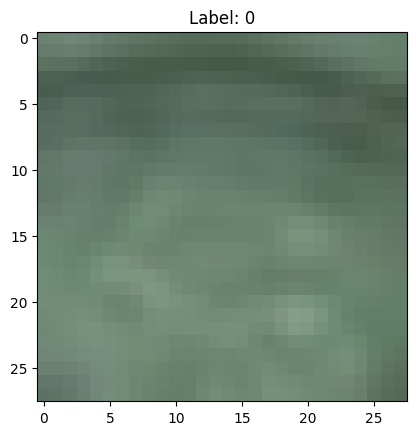

CPU times: total: 719 ms
Wall time: 125 ms


In [25]:
%%time
for i, (images, labels) in enumerate(test_dataloader):
    print(f"Batch {i + 1}:")
    print(f"  - Images shape: {images.shape}")
    print(f"  - Labels: {labels}")

    for j in range(images.shape[0]):
        image = images[j].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f"Label: {labels[j]}")
        plt.show()

    break

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


# 1. Автоэнкодер из лекции (бейзлайн решение)


In [39]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_c, input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_c * input_dim * input_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)


class Decoder(nn.Module):
    def __init__(self, latent_dims, input_c, input_dim):
        self.input_c = input_c
        self.input_dim = input_dim
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 512)
        self.linear3 = nn.Linear(512, input_c * input_dim * input_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, self.input_c, self.input_dim, self.input_dim))


class Autoencoder(nn.Module):
    def __init__(self, latent_dims=16, input_c=1, input_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_c, input_dim)
        self.decoder = Decoder(latent_dims, input_c, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [40]:
num_workers = os.cpu_count()
num_workers

12

Batch 1:
  - Images shape: torch.Size([1, 3, 28, 28])
  - Labels: ('0',)


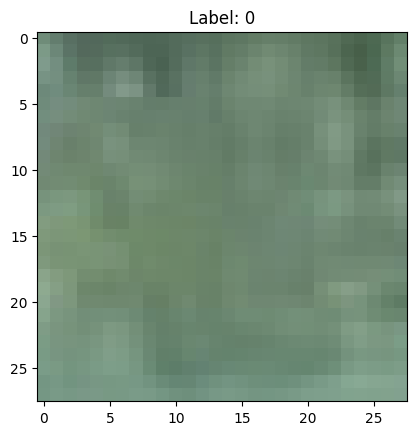

CPU times: total: 594 ms
Wall time: 127 ms


In [41]:
%%time
for i, (images, labels) in enumerate(test_dataloader):
    print(f"Batch {i + 1}:")
    print(f"  - Images shape: {images.shape}")
    print(f"  - Labels: {labels}")

    for j in range(images.shape[0]):
        image = images[j].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f"Label: {labels[j]}")
        plt.show()

    break

In [42]:
%%time
model = Autoencoder(input_c=3, input_dim=28, latent_dims=16).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(5)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device)  # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat) ** 2).sum()
        running_loss += loss / batch_size
        loss.backward()
        opt.step()

    model.eval()
    val_count = 0
    val_loss = 0
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device)
            reconstruction = model(x)
            loss = ((x - reconstruction) ** 2).sum()
            val_loss += loss / batch_size
    print(
        f"epoch {epoch+1}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}"
    )

 20%|██        | 1/5 [00:11<00:44, 11.15s/it]

epoch 1: train loss 5.411561965942383, validation loss 16.2250919342041


 40%|████      | 2/5 [00:23<00:34, 11.61s/it]

epoch 2: train loss 4.335704326629639, validation loss 14.246164321899414


 60%|██████    | 3/5 [00:34<00:23, 11.59s/it]

epoch 3: train loss 3.628589630126953, validation loss 14.451093673706055


 80%|████████  | 4/5 [00:46<00:11, 11.73s/it]

epoch 4: train loss 3.3963940143585205, validation loss 14.12849235534668


100%|██████████| 5/5 [00:57<00:00, 11.54s/it]

epoch 5: train loss 3.1133880615234375, validation loss 14.537548065185547
CPU times: total: 5min 41s
Wall time: 57.7 s


In [49]:
summary(model, input_size=(3, 28, 28))

Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Linear: 2-1                       1,204,736
|    └─Linear: 2-2                       65,664
|    └─Linear: 2-3                       2,064
├─Decoder: 1-2                           --
|    └─Linear: 2-4                       2,176
|    └─Linear: 2-5                       66,048
|    └─Linear: 2-6                       1,206,576
Total params: 2,547,264
Trainable params: 2,547,264
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Linear: 2-1                       1,204,736
|    └─Linear: 2-2                       65,664
|    └─Linear: 2-3                       2,064
├─Decoder: 1-2                           --
|    └─Linear: 2-4                       2,176
|    └─Linear: 2-5                       66,048
|    └─Linear: 2-6                       1,206,576
Total params: 2,547,264
Trainable params: 2,547,264
Non-trainable params: 0

In [44]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:
        true.append(int(y[0]))
        x = x.to(device)  # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction) ** 2).sum()
        losses.append(loss.item())

thresholds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0

        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1

    thresholds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 10.486000000000002


In [45]:
tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:
    x = x.to(device)  # GPU
    reconstruction = model(x)
    loss = ((x - reconstruction) ** 2).sum()

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0

    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1

tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(
    f"True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}, Threshold: {np.quantile(best_tresholds, 0.9)}"
)

True Positive Rate: 0.791, True Negative Rate: 0.958, Threshold: 10.486000000000002


In [46]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:
        true.append(int(y[0]))
        x = x.to(device)  # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction) ** 2).sum()
        losses.append(loss.item())

thresholds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0

        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1

    thresholds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(
            f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}"
        )

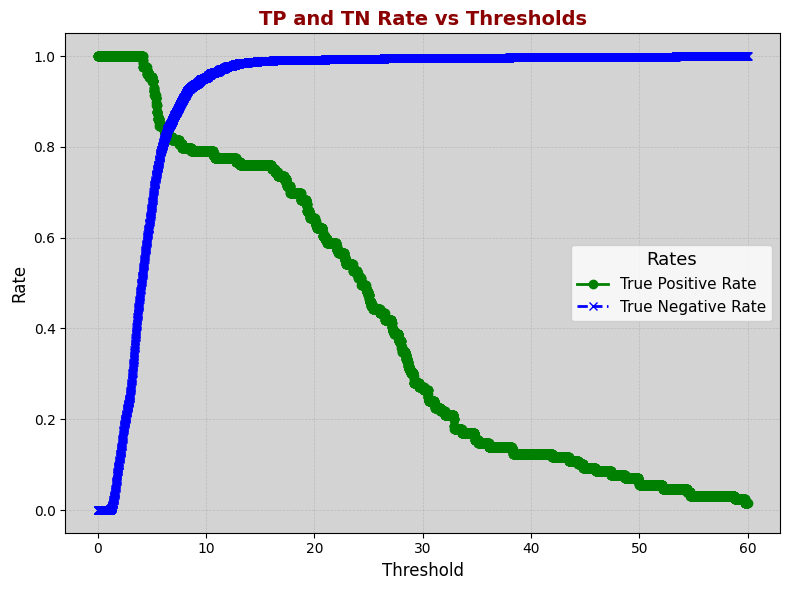

In [47]:
plt.figure(figsize=(8, 6))

plt.plot(
    thresholds,
    tp_rate,
    label="True Positive Rate",
    color="green",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=6,
)
plt.plot(
    thresholds,
    tn_rate,
    label="True Negative Rate",
    color="blue",
    linestyle="--",
    linewidth=2,
    marker="x",
    markersize=6,
)

plt.title(
    "TP and TN Rate vs Thresholds", fontsize=14, fontweight="bold", color="darkred"
)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)

plt.gca().set_facecolor("lightgray")
plt.legend(title="Rates", title_fontsize="13", loc="best", fontsize=11)

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [10]:
torch.cuda.empty_cache()

# 2. VAE из лекции

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, input_c):
        self.input_c = input_c
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 512)
        self.linear3 = nn.Linear(512, input_c * 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, self.input_c, 28, 28))


class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, input_c):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_c * 784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1 / 2).sum()
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims=16, input_c=1):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, input_c)
        self.decoder = Decoder(latent_dims, input_c)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
model = VariationalAutoencoder(input_c=3).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(5)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device)  # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat) ** 2).sum() + model.encoder.kl
        running_loss += loss / batch_size
        loss.backward()
        opt.step()

    model.eval()
    val_count = 0
    val_loss = 0
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device)  # GPU
            reconstruction = model(x)
            loss = ((x - reconstruction) ** 2).sum()
            val_loss += loss / batch_size
    print(
        f"epoch {epoch+1}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}"
    )

 20%|██        | 1/5 [00:12<00:49, 12.28s/it]

epoch 1: train loss 11.56009578704834, validation loss 16.14698600769043


 40%|████      | 2/5 [00:24<00:36, 12.31s/it]

epoch 2: train loss 10.539739608764648, validation loss 15.121967315673828


 60%|██████    | 3/5 [00:37<00:24, 12.39s/it]

epoch 3: train loss 10.54422664642334, validation loss 16.0620059967041


 80%|████████  | 4/5 [00:49<00:12, 12.50s/it]

epoch 4: train loss 10.52216625213623, validation loss 15.940418243408203


100%|██████████| 5/5 [01:02<00:00, 12.51s/it]

epoch 5: train loss 10.530033111572266, validation loss 15.496667861938477


In [13]:
summary(model, input_size=(3, 28, 28))

Layer (type:depth-idx)                   Param #
├─VariationalEncoder: 1-1                --
|    └─Linear: 2-1                       1,204,736
|    └─Linear: 2-2                       8,208
|    └─Linear: 2-3                       8,208
├─Decoder: 1-2                           --
|    └─Linear: 2-4                       2,176
|    └─Linear: 2-5                       66,048
|    └─Linear: 2-6                       1,206,576
Total params: 2,495,952
Trainable params: 2,495,952
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─VariationalEncoder: 1-1                --
|    └─Linear: 2-1                       1,204,736
|    └─Linear: 2-2                       8,208
|    └─Linear: 2-3                       8,208
├─Decoder: 1-2                           --
|    └─Linear: 2-4                       2,176
|    └─Linear: 2-5                       66,048
|    └─Linear: 2-6                       1,206,576
Total params: 2,495,952
Trainable params: 2,495,952
Non-trainable params: 0

In [14]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:
        true.append(int(y[0]))
        x = x.to(device)  # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction) ** 2).sum() + model.encoder.kl
        losses.append(loss.item())

thresolds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0

        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1

    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 16.66


In [15]:
tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:
    x = x.to(device)  # GPU
    reconstruction = model(x)
    loss = ((x - reconstruction) ** 2).sum() + model.encoder.kl

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0

    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1

tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(
    f"True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}, Threshold: {np.quantile(best_tresholds, 0.9)}"
)

True Positive Rate: 0.89, True Negative Rate: 0.90, Threshold: 16.66


In [16]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:
        true.append(int(y[0]))
        x = x.to(device)  # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction) ** 2).sum()
        losses.append(loss.item())

thresolds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0

        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1

    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(
            f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}"
        )

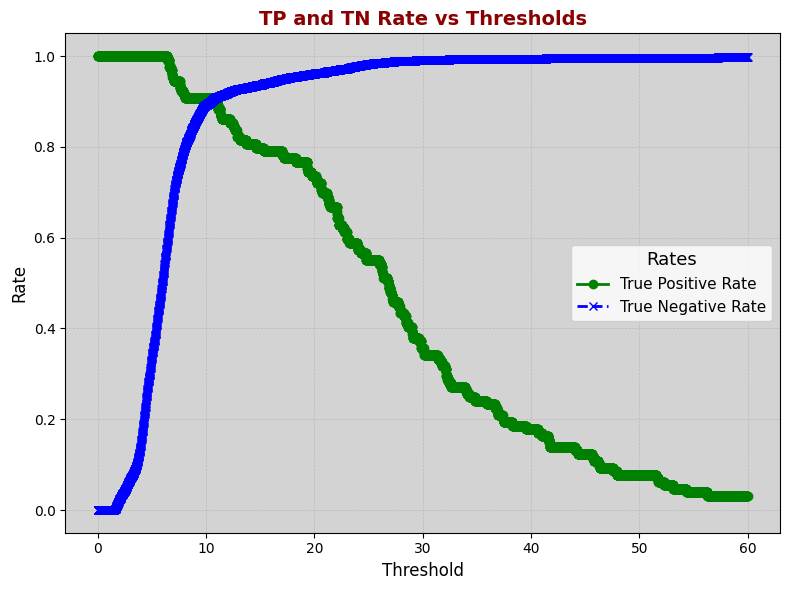

In [17]:
plt.figure(figsize=(8, 6))

plt.plot(
    thresolds,
    tp_rate,
    label="True Positive Rate",
    color="green",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=6,
)
plt.plot(
    thresolds,
    tn_rate,
    label="True Negative Rate",
    color="blue",
    linestyle="--",
    linewidth=2,
    marker="x",
    markersize=6,
)

plt.title(
    "TP and TN Rate vs Thresholds", fontsize=14, fontweight="bold", color="darkred"
)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)

plt.gca().set_facecolor("lightgray")
plt.legend(title="Rates", title_fontsize="13", loc="best", fontsize=11)

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
torch.cuda.empty_cache()

# 3.Автоэнкодер со сверткой

In [27]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_c=3):
        super(ConvAutoencoder, self).__init__()

        ## Encoder ##
        self.conv1 = nn.Conv2d(input_c, 32, 3, padding=1)  # 3 -> 32
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32 -> 64
        self.conv2_bn = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # Пулинг с размером 2x2

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 64 -> 128
        self.conv3_bn = nn.BatchNorm2d(128)

        ## Decoder ##
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 128 -> 64
        self.t_conv1_bn = nn.BatchNorm2d(64)

        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # 64 -> 32
        self.t_conv2_bn = nn.BatchNorm2d(32)

        self.t_conv3 = nn.ConvTranspose2d(32, input_c, 3, padding=1)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        ## Encoder ##
        x = F.relu(self.conv1_bn(self.conv1(x)))  # 28x28 -> 28x28
        x = self.pool(x)  # 28x28 -> 14x14

        x = F.relu(self.conv2_bn(self.conv2(x)))  # 14x14 -> 14x14
        x = self.pool(x)  # 14x14 -> 7x7

        x = F.relu(self.conv3_bn(self.conv3(x)))  # 7x7 -> 7x7

        ## Decoder ##
        x = F.relu(self.t_conv1_bn(self.t_conv1(x)))  # 7x7 -> 14x14
        x = self.dropout(x)

        x = F.relu(self.t_conv2_bn(self.t_conv2(x)))  # 14x14 -> 28x28
        x = self.dropout(x)

        x = torch.sigmoid(self.t_conv3(x))  # 28x28 -> 28x28

        return x

In [28]:
model = ConvAutoencoder(input_c=3).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(20)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device)  # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat) ** 2).sum()
        running_loss += loss / batch_size
        loss.backward()
        opt.step()

    model.eval()
    val_count = 0
    val_loss = 0
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device)  # GPU
            reconstruction = model(x)
            loss = ((x - reconstruction) ** 2).sum()
            val_loss += loss / batch_size
    print(
        f"epoch {epoch+1}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}"
    )

  5%|▌         | 1/20 [00:12<03:50, 12.15s/it]

epoch 1: train loss 29.499719619750977, validation loss 11.661151885986328


 10%|█         | 2/20 [00:23<03:35, 11.95s/it]

epoch 2: train loss 3.340859889984131, validation loss 8.333906173706055


 15%|█▌        | 3/20 [00:35<03:18, 11.65s/it]

epoch 3: train loss 2.268207550048828, validation loss 7.0850934982299805


 20%|██        | 4/20 [00:46<03:03, 11.45s/it]

epoch 4: train loss 1.8334285020828247, validation loss 6.333014488220215


 25%|██▌       | 5/20 [00:57<02:51, 11.40s/it]

epoch 5: train loss 1.5621341466903687, validation loss 5.422267913818359


 30%|███       | 6/20 [01:09<02:39, 11.37s/it]

epoch 6: train loss 1.3891407251358032, validation loss 5.055715560913086


 35%|███▌      | 7/20 [01:20<02:27, 11.33s/it]

epoch 7: train loss 1.272438883781433, validation loss 4.642661094665527


 40%|████      | 8/20 [01:31<02:15, 11.26s/it]

epoch 8: train loss 1.1910269260406494, validation loss 4.516026496887207


 45%|████▌     | 9/20 [01:42<02:04, 11.30s/it]

epoch 9: train loss 1.101896047592163, validation loss 4.585298538208008


 50%|█████     | 10/20 [01:54<01:53, 11.30s/it]

epoch 10: train loss 1.0490771532058716, validation loss 4.078090190887451


 55%|█████▌    | 11/20 [02:05<01:41, 11.24s/it]

epoch 11: train loss 0.9998079538345337, validation loss 4.068493366241455


 60%|██████    | 12/20 [02:16<01:30, 11.26s/it]

epoch 12: train loss 0.9622799158096313, validation loss 4.175233840942383


 65%|██████▌   | 13/20 [02:27<01:18, 11.28s/it]

epoch 13: train loss 0.9132661819458008, validation loss 3.9400813579559326


 70%|███████   | 14/20 [02:38<01:07, 11.25s/it]

epoch 14: train loss 0.8863169550895691, validation loss 3.9596362113952637


 75%|███████▌  | 15/20 [02:50<00:56, 11.26s/it]

epoch 15: train loss 0.8686503171920776, validation loss 3.5868818759918213


 80%|████████  | 16/20 [03:01<00:45, 11.27s/it]

epoch 16: train loss 0.841858983039856, validation loss 3.431673049926758


 85%|████████▌ | 17/20 [03:12<00:33, 11.28s/it]

epoch 17: train loss 0.8326646089553833, validation loss 3.158968448638916


 90%|█████████ | 18/20 [03:24<00:22, 11.23s/it]

epoch 18: train loss 0.8078896999359131, validation loss 3.2997641563415527


 95%|█████████▌| 19/20 [03:35<00:11, 11.36s/it]

epoch 19: train loss 0.7831007838249207, validation loss 3.4243602752685547


100%|██████████| 20/20 [03:47<00:00, 11.37s/it]

epoch 20: train loss 0.7672815322875977, validation loss 2.8812785148620605


In [29]:
summary(model, input_size=(3, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            18,496
├─BatchNorm2d: 1-4                       128
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,856
├─BatchNorm2d: 1-7                       256
├─ConvTranspose2d: 1-8                   32,832
├─BatchNorm2d: 1-9                       128
├─ConvTranspose2d: 1-10                  8,224
├─BatchNorm2d: 1-11                      64
├─ConvTranspose2d: 1-12                  867
├─Dropout: 1-13                          --
Total params: 135,811
Trainable params: 135,811
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            18,496
├─BatchNorm2d: 1-4                       128
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,856
├─BatchNorm2d: 1-7                       256
├─ConvTranspose2d: 1-8                   32,832
├─BatchNorm2d: 1-9                       128
├─ConvTranspose2d: 1-10                  8,224
├─BatchNorm2d: 1-11                      64
├─ConvTranspose2d: 1-12                  867
├─Dropout: 1-13                          --
Total params: 135,811
Trainable params: 135,811
Non-trainable params: 0

In [30]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)
        # print(f"threshold = {(thresh / 10):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}")

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 0.6760000000000002


In [31]:
tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:

    x = x.to(device) # GPU
    reconstruction = model(x)
    loss = ((x - reconstruction)**2).sum()

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0
    
    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1
    
tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(f"True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}, Threshold: {np.quantile(best_tresholds, 0.9)}")

True Positive Rate: 0.93, True Negative Rate: 0.77, Threshold: 0.6760000000000002


In [32]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.3f}")

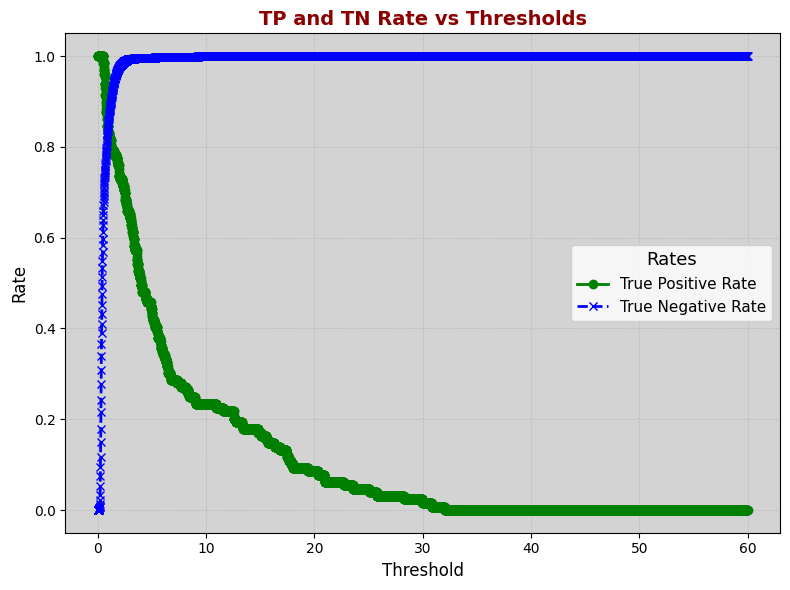

In [33]:
plt.figure(figsize=(8, 6))


plt.plot(
    thresolds,
    tp_rate,
    label="True Positive Rate",
    color="green",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=6,
)
plt.plot(
    thresolds,
    tn_rate,
    label="True Negative Rate",
    color="blue",
    linestyle="--",
    linewidth=2,
    marker="x",
    markersize=6,
)

plt.title(
    "TP and TN Rate vs Thresholds", fontsize=14, fontweight="bold", color="darkred"
)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)

plt.gca().set_facecolor("lightgray")
plt.legend(title="Rates", title_fontsize="13", loc="best", fontsize=11)

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()